## Project 1 – Parts g & h: Bias–Variance with Bootstrap and Cross‑Validation

# Imports og hjelpefunksjoner

In [1]:
from functions import *

seed = 2018

# Del g: Bootstrap-estimat av Bias, Varians og MSE (OLS)

For hver polynomgrad d trener du OLS mange ganger på bootstrap-utvalg av treningsdataene. Hver gang predikerer du en hel kurve på et fast grid av x-verdier. Deretter bruker du disse mange kurvene til å anslå bias^2, varians og mse som funksjon av x (og til slutt snitter du over gridet for å få ett tall per grad).

In [2]:
#Define n
n_points_list = [100, 500, 1000, 2000, 5000, 7000, 10000]
#Define degrees
degrees = list(range(1, 15)) #polynomial degrees

B = 200 #number of bootstrap replicates

# Make dataset 

In [3]:
results_by_n = {}

for n_points in n_points_list:

    (train, test, full) = make_data(n=n_points)

    x_train, y_train = train
    x_test, y_test = test
    x_all, y_all, y_all_clean = full 

    boot = bootstrap(degrees, x_train, x_test, y_train, y_test, B, seed=seed)
    
    #Unpack
    deg = boot["degree"]

    train_mse = boot["train_mse"]
    test_mse  = boot["test_mse"]

    mse_boots = boot["mse_boots"]
    bias_boots = boot["bias2_boots"]
    var_boots = boot["var_boots"]

    results_by_n[n_points] = {
        "degree": np.asarray(deg),
        "train_mse": np.asarray(train_mse),
        "test_mse": np.asarray(test_mse),
        "mse_boots": np.asarray(mse_boots),
        "bias_boots": np.asarray(bias_boots),
        "var_boots": np.asarray(var_boots),
    }

# Plott: Train/Test-MSE vs grad (OLS)

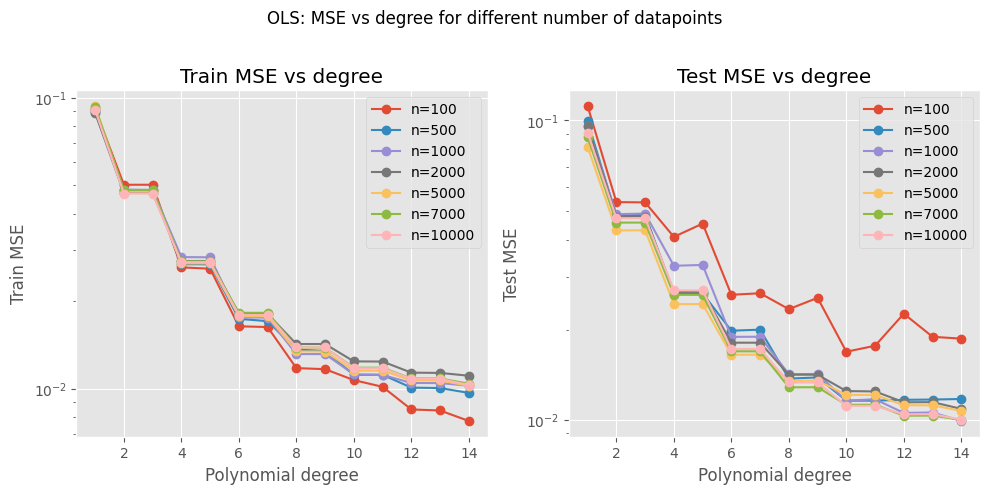

In [4]:
# --- plotting ---
plt.figure(figsize=(10, 4.8))

#Left: Train MSE
plt.subplot(1, 2, 1)
for n_points in n_points_list:
    d = results_by_n[n_points]["degree"]
    tr = results_by_n[n_points]["train_mse"]
    plt.semilogy(d, tr, marker='o', linewidth=1.5, label=f'n={n_points}')
plt.xlabel('Polynomial degree')
plt.ylabel('Train MSE')
plt.title('Train MSE vs degree')
plt.legend()
plt.tight_layout()

#Right: Test MSE
plt.subplot(1, 2, 2)
for n_points in n_points_list:
    d = results_by_n[n_points]["degree"]
    te = results_by_n[n_points]["test_mse"]
    plt.semilogy(d, te, marker='o', linewidth=1.5, label=f'n={n_points}')
plt.xlabel('Polynomial degree')
plt.ylabel('Test MSE')
plt.title('Test MSE vs degree')
plt.legend()
plt.tight_layout()

plt.suptitle('OLS: MSE vs degree for different number of datapoints', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# (valgfritt) lagre figur
# plt.savefig('mse_vs_degree_by_npoints.png', dpi=200, bbox_inches='tight')

# Plott: Bias², Varians, MSE (bootstrap) vs grad

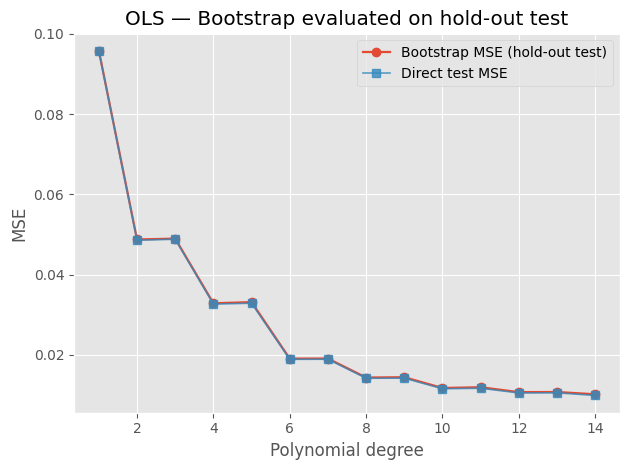

In [5]:
"""
Choose n = 1000
"""

plt.figure()
plt.plot(deg, results_by_n[1000]["mse_boots"], marker='o', linewidth=1.6,
         label='Bootstrap MSE (hold-out test)')
# valgfritt: legg på direkte test-MSE fra én fit per grad (referanse)
plt.plot(deg, results_by_n[1000]["test_mse"], marker='s', linewidth=1.2, alpha=0.8,
         label='Direct test MSE')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('OLS — Bootstrap evaluated on hold-out test')
plt.legend()
plt.tight_layout()
plt.show()

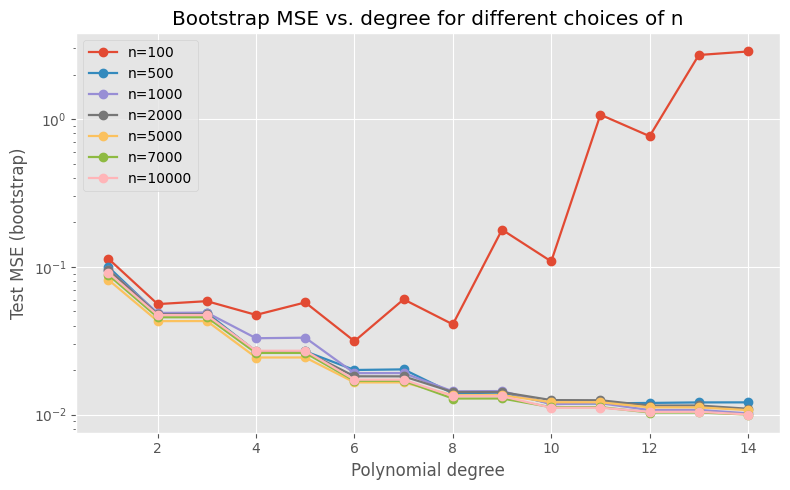

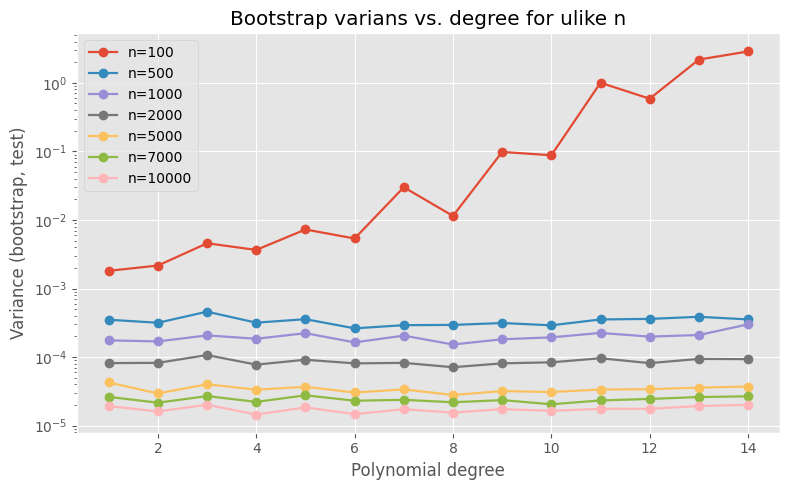

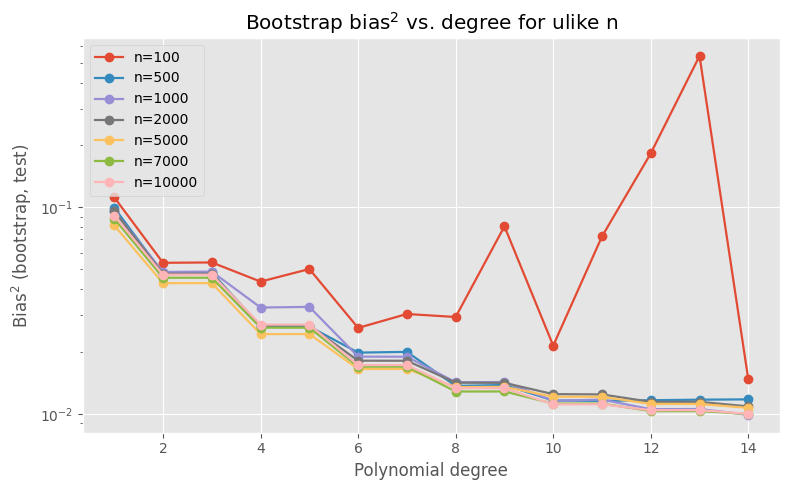

In [11]:
# --- 1) MSE (bootstrap) vs degree ---
plt.figure(figsize=(8,5))
for n in n_points_list:
    plt.semilogy(degrees, results_by_n[n]["mse_boots"], marker='o', linewidth=1.6, label=f"n={n}")
plt.xlabel("Polynomial degree")
plt.ylabel("Test MSE (bootstrap)")
plt.title("Bootstrap MSE vs. degree for different choices of n")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2) Varians (bootstrap) vs degree ---
plt.figure(figsize=(8,5))
for n in n_points_list:
    plt.semilogy(degrees, results_by_n[n]["var_boots"], marker='o', linewidth=1.6, label=f"n={n}")
plt.xlabel("Polynomial degree")
plt.ylabel("Variance (bootstrap, test)")
plt.title("Bootstrap varians vs. degree for ulike n")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3) Bias^2 (bootstrap) vs degree ---
plt.figure(figsize=(8,5))
for n in n_points_list:
    plt.semilogy(degrees, results_by_n[n]["bias_boots"], marker='o', linewidth=1.6, label=f"n={n}")
plt.xlabel("Polynomial degree")
plt.ylabel(r"Bias$^2$ (bootstrap, test)")
plt.title(r"Bootstrap bias$^2$ vs. degree for ulike n")
plt.legend()
plt.tight_layout()
plt.show()

# (valgfritt) log-akse hvis kurvene spenner mye:
# for plt i over, legg evt. inn: plt.yscale("log")


# Del h: k-fold CV for OLS – MSE vs grad

In [ ]:
#Generate a new dataset for part h) k-fold 
n_k_fold = 2000 

(train, test, full) = make_data(n=n_k_fold)

x_train, y_train = train
x_test, y_test = test
x_all, y_all, y_all_clean = full 

K = 10 #number of k-folds

lambdas = np.logspace(-4, -1, 15) #feilen "straffen" i ridge og lasso

In [ ]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, K, x_train, y_train) for d in degrees])

# Plot

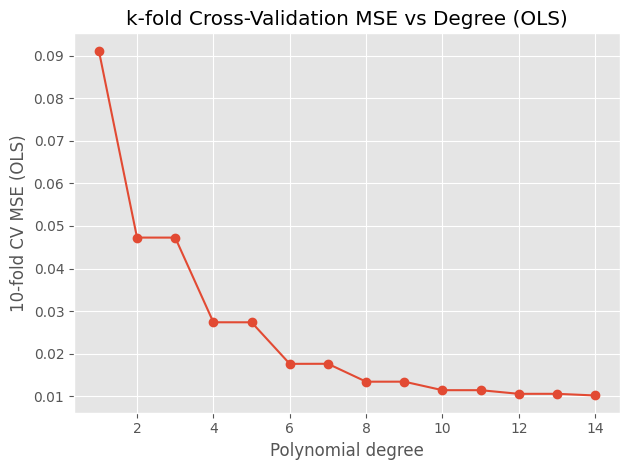

The best polynomial degree for ols is 14


In [ ]:
plt.figure()
plt.plot(degrees, cv_mse_ols, marker='o')
plt.xlabel('Polynomial degree')
plt.ylabel(f'{K}-fold CV MSE (OLS)')
plt.title('k-fold Cross-Validation MSE vs Degree (OLS)')
plt.tight_layout()
plt.show()
best_deg_ols = int(degrees[np.argmin(cv_mse_ols)])

print(f"The best polynomial degree for ols is: {best_deg_ols}")

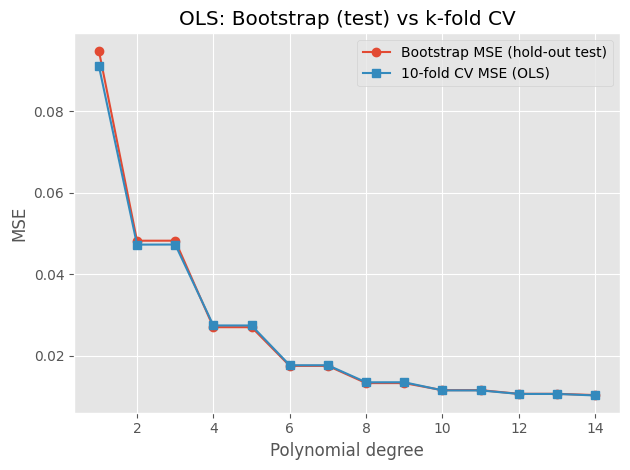

In [ ]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, K, x_train, y_train) for d in degrees])

plt.figure()
plt.plot(deg, boot["mse_boots"], marker='o', label='Bootstrap MSE (hold-out test)')
plt.plot(deg, cv_mse_ols,            marker='s', label=f'{K}-fold CV MSE (OLS)')
plt.xlabel('Polynomial degree'); plt.ylabel('MSE')
plt.title('OLS: Bootstrap (test) vs k-fold CV')
plt.legend(); plt.tight_layout(); plt.show()

# CV-kurver for Ridge og Lasso (utvalgte grader)

In [ ]:
best_ridge, best_lasso = {}, {}

cv_mse_ridge = {d: cv_for_methods('ridge', d, lambdas, K, x_train, y_train)
for d in degrees}
cv_mse_lasso = {d: cv_for_methods('lasso', d, lambdas, K, x_train, y_train) 
for d in degrees}

# Plot

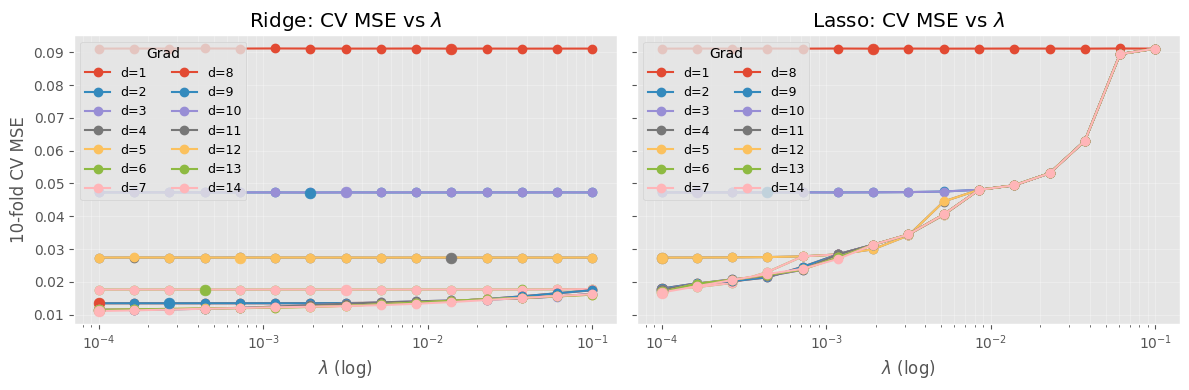

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey = True)
ax_ridge, ax_lasso = axes 

#Ridge 
for d in degrees:
    results_ridge = cv_mse_ridge[d]
    order = np.argsort(results_ridge["lambdas"])
    ax_ridge.semilogx(results_ridge["lambdas"][order], results_ridge["cv_mse"][order], marker='o', linewidth=1.5, label=f'd={d}')
    ax_ridge.scatter(results_ridge["best_lambda"], results_ridge["best_mse"], s=60, zorder=3)

ax_ridge.set_title(r'Ridge: CV MSE vs $\lambda$')
ax_ridge.set_xlabel(r'$\lambda$ (log)')
ax_ridge.set_ylabel(f'{K}-fold CV MSE')
ax_ridge.grid(True, which='both', alpha=0.3)
ax_ridge.legend(title='Grad', ncol=2, fontsize=9)


# Lasso
for d in degrees:
    results_lasso = cv_mse_lasso[d]
    order = np.argsort(results_lasso["lambdas"])
    ax_lasso.semilogx(results_lasso["lambdas"][order], results_lasso["cv_mse"][order], marker='o', linewidth=1.5, label=f'd={d}')
    ax_lasso.scatter(results_lasso["best_lambda"], results_lasso["best_mse"], s=60, zorder=3)

ax_lasso.set_title(r'Lasso: CV MSE vs $\lambda$')
ax_lasso.set_xlabel(r'$\lambda$ (log)')
ax_lasso.grid(True, which='both', alpha=0.3)
ax_lasso.legend(title='Grad', ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_61039/1868609986.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")  # eller "plasma", "magma", "cividis", ...


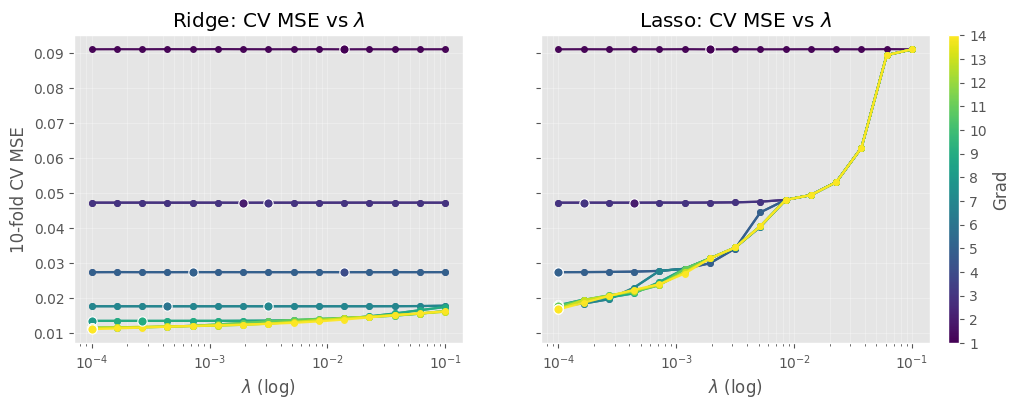

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax_ridge, ax_lasso = axes

# --- én fargeskala for grad ---
deg_min, deg_max = min(degrees), max(degrees)
norm = Normalize(vmin=deg_min, vmax=deg_max)
cmap = get_cmap("viridis")  # eller "plasma", "magma", "cividis", ...

def color_for_degree(d):
    return cmap(norm(d))

# RIDGE
for d in degrees:
    res_ridge = cv_mse_ridge[d]
    order_ridge = np.argsort(res_ridge["lambdas"])
    x_ridge = res_ridge["lambdas"][order]
    y_ridge = res_ridge["cv_mse"][order]
    c = color_for_degree(d)

    ax_ridge.semilogx(x_ridge, y_ridge, marker='o', linewidth=1.6, markersize=4, color=c, alpha=0.95)
    ax_ridge.scatter(res_ridge["best_lambda"], res_ridge["best_mse"], s=45, zorder=3,
                     color=c, edgecolor="white", linewidth=0.8)

ax_ridge.set_title(r'Ridge: CV MSE vs $\lambda$')
ax_ridge.set_xlabel(r'$\lambda$ (log)')
ax_ridge.set_ylabel(f'{K}-fold CV MSE')
ax_ridge.grid(True, which='both', alpha=0.3)

# LASSO
for d in degrees:
    res_lasso = cv_mse_lasso[d]
    order_lasso = np.argsort(res_lasso["lambdas"])
    x_lasso = res_lasso["lambdas"][order]
    y_lasso = res_lasso["cv_mse"][order]
    c = color_for_degree(d)

    ax_lasso.semilogx(x_lasso, y_lasso, marker='o', linewidth=1.6, markersize=4, color=c, alpha=0.95)
    ax_lasso.scatter(res_lasso["best_lambda"], res_lasso["best_mse"], s=45, zorder=3,
                     color=c, edgecolor="white", linewidth=0.8)

ax_lasso.set_title(r'Lasso: CV MSE vs $\lambda$')
ax_lasso.set_xlabel(r'$\lambda$ (log)')
ax_lasso.grid(True, which='both', alpha=0.3)


# Felles colorbar for grad
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(None)

cbar = fig.colorbar(
    sm, ax=axes, location='right',
    pad=0.02,        # litt luft mellom plott og colorbar
    fraction=0.06,   # hvor bred colorbaren er relativt til aksene
    aspect=28        # høyde/bredde-forhold på selve baren
)
cbar.set_label('Grad')

# Penere og diskrete ticks (heltallige grader)
cbar.set_ticks(np.arange(deg_min, deg_max + 1))

#plt.tight_layout()
plt.show()

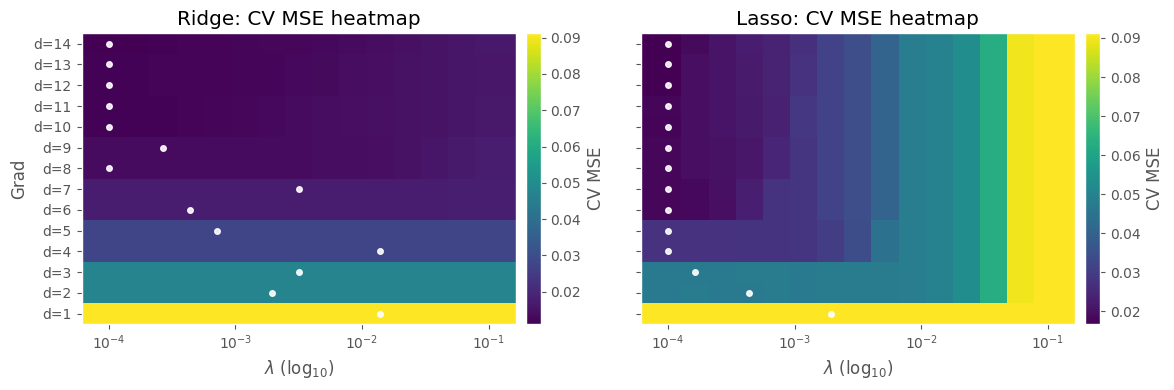

In [ ]:
def _build_heatmap_matrix(results_by_deg):
    """
    results_by_deg: dict[d] -> {"lambdas": array, "cv_mse": array, "best_lambda": float, "best_mse": float}
    Returnerer:
        degrees_sorted (list),
        lambdas_common (array),
        H (2D array shape [n_deg, n_lam]) med CV-MSE,
        best_points (list of tuples (row_i, best_lambda, best_mse))
    """
    degrees_sorted = sorted(results_by_deg.keys())
    # Samle ALLE lambdaer (kan være identiske for alle d; hvis ikke, lager vi felles grid)
    all_lams = np.unique(np.concatenate([np.asarray(results_by_deg[d]["lambdas"]) for d in degrees_sorted]))
    # Vi jobber i log10-rom for jevnere interpolasjon og akse
    lam_log = np.log10(all_lams)
    lam_log.sort()
    lambdas_common = 10**lam_log

    H = np.zeros((len(degrees_sorted), len(lambdas_common)))
    best_points = []

    for i, d in enumerate(degrees_sorted):
        lam_d = np.asarray(results_by_deg[d]["lambdas"])
        mse_d = np.asarray(results_by_deg[d]["cv_mse"])
        order = np.argsort(lam_d)
        lam_d = lam_d[order]
        mse_d = mse_d[order]
        # Interpoler i log-lambda
        H[i, :] = np.interp(lam_log, np.log10(lam_d), mse_d)
        best_points.append((i, results_by_deg[d]["best_lambda"], results_by_deg[d]["best_mse"]))
    return degrees_sorted, lambdas_common, H, best_points

# Bygg matriser
deg_r, lam_r, H_r, best_r = _build_heatmap_matrix(cv_mse_ridge)
deg_l, lam_l, H_l, best_l = _build_heatmap_matrix(cv_mse_lasso)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axR, axL = axes

def _plot_heat(ax, lambdas, degrees, H, title, best_points):
    # x-akse i log10(lambda) men viser ticklabels som lambda
    x = np.log10(lambdas)
    # pcolormesh trenger kant-gitter; lag fra sentre
    x_edges = np.concatenate(([x[0] - (x[1]-x[0])], (x[:-1]+x[1:])/2, [x[-1] + (x[-1]-x[-2])]))
    y = np.arange(len(degrees), dtype=float)
    y_edges = np.concatenate(([y[0]-0.5], y[1:]-0.5, [y[-1]+0.5]))

    mesh = ax.pcolormesh(x_edges, y_edges, H, shading='auto')
    cbar = plt.colorbar(mesh, ax=ax, pad=0.02)
    cbar.set_label('CV MSE')

    # Marker beste punkt per grad
    for row_i, blam, bmse in best_points:
        ax.plot(np.log10(blam), row_i, marker='o', markersize=4, mec='white', mfc='white', alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel(r'$\lambda$ (log$_{10}$)')
    ax.set_yticks(np.arange(len(degrees)))
    ax.set_yticklabels([f'd={d}' for d in degrees])
    ax.grid(False)

    # Penere x-ticks: velg noen få lambda-verdier
    xticks_log = np.log10(np.array([1e-4, 1e-3, 1e-2, 1e-1]))
    ax.set_xticks(xticks_log)
    ax.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$'])

_plot_heat(axR, lam_r, deg_r, H_r, 'Ridge: CV MSE heatmap', best_r)
axR.set_ylabel('Grad')

_plot_heat(axL, lam_l, deg_l, H_l, 'Lasso: CV MSE heatmap', best_l)

plt.tight_layout()
plt.show()


<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_61039/2406724670.py:41: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"{title_prefix} —- best: degree={d_star}, $\lambda$ = {lam_star:.2e}, MSE={mse_star:.4f}")


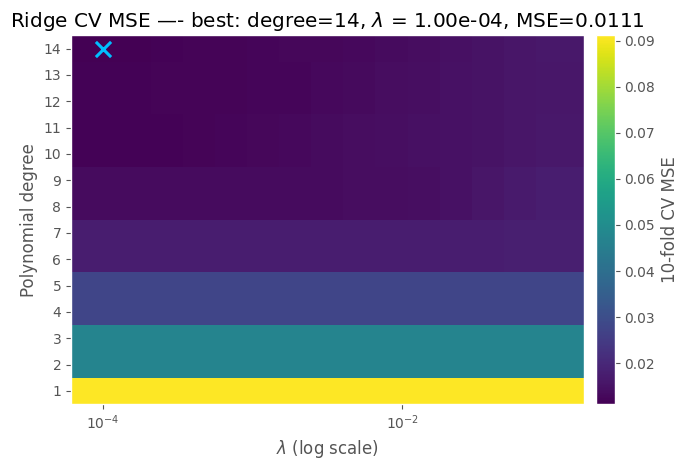

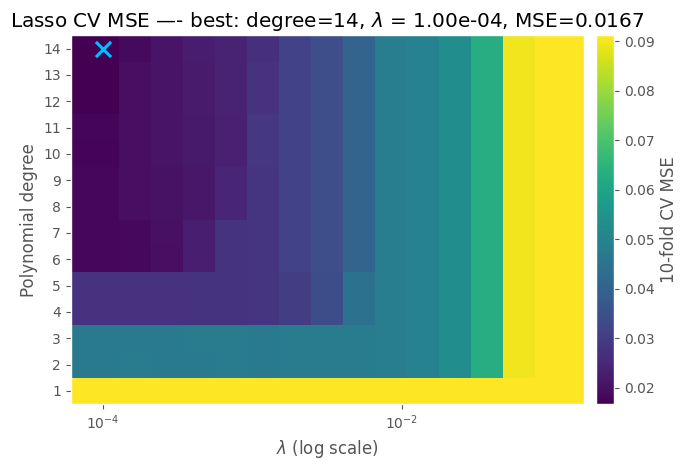

Best by CV (heatmap) — Ridge: {'degree': 14, 'lambda': np.float64(0.0001), 'cv_mse': np.float64(0.011088637726152284)}
Best by CV (heatmap) — Lasso: {'degree': 14, 'lambda': np.float64(0.0001), 'cv_mse': np.float64(0.016727687246578873)}


In [ ]:
def _build_heatmap_matrix(results_by_deg):
    degrees_sorted = sorted(results_by_deg.keys())
    all_lams = np.unique(np.concatenate(
        [np.asarray(results_by_deg[d]["lambdas"]) for d in degrees_sorted]
    ))
    lam_log = np.log10(all_lams); lam_log.sort()
    lambdas_common = 10**lam_log

    H = np.zeros((len(degrees_sorted), len(lambdas_common)))
    for i, d in enumerate(degrees_sorted):
        lam_d = np.asarray(results_by_deg[d]["lambdas"])
        mse_d = np.asarray(results_by_deg[d]["cv_mse"])
        order = np.argsort(lam_d)
        H[i, :] = np.interp(lam_log, np.log10(lam_d[order]), mse_d[order])
    return degrees_sorted, lambdas_common, H

def plot_cv_heatmap_with_best(results_by_deg, title_prefix, n_k_folds=10, cmap="viridis"):
    degrees_sorted, lambdas_common, H = _build_heatmap_matrix(results_by_deg)

    # global best in the heatmap
    i_star, j_star = np.unravel_index(np.argmin(H), H.shape)
    d_star = degrees_sorted[i_star]
    lam_star = lambdas_common[j_star]
    mse_star = H[i_star, j_star]

    fig, ax = plt.subplots(figsize=(7.0, 4.8))

    # make pcolormesh from centers (log λ on x, degree index on y)
    x = np.log10(lambdas_common)
    x_edges = np.concatenate(([x[0]-(x[1]-x[0])], (x[:-1]+x[1:])/2, [x[-1]+(x[-1]-x[-2])]))
    y = np.arange(len(degrees_sorted), dtype=float)
    y_edges = np.concatenate(([y[0]-0.5], y[1:]-0.5, [y[-1]+0.5]))

    mesh = ax.pcolormesh(x_edges, y_edges, H, shading='auto', cmap=cmap)
    cbar = plt.colorbar(mesh, ax=ax, pad=0.02)
    cbar.set_label(f'{K}-fold CV MSE')

    # mark global best with a cross
    ax.scatter(np.log10(lam_star), i_star, marker='x', s=120, linewidths=2.2, color='deepskyblue', zorder=3)

    ax.set_title(f"{title_prefix} —- best: degree={d_star}, $\lambda$ = {lam_star:.2e}, MSE={mse_star:.4f}")
    ax.set_xlabel(r'$\lambda$ (log scale)')
    ax.set_ylabel('Polynomial degree')
    ax.set_yticks(np.arange(len(degrees_sorted)))
    ax.set_yticklabels([str(d) for d in degrees_sorted])
    xticks = np.array([1e-6, 1e-4, 1e-2, 1e0, 1e2])
    xticks = xticks[(xticks>=lambdas_common.min()) & (xticks<=lambdas_common.max())]
    if len(xticks) > 0:
        ax.set_xticks(np.log10(xticks))
        ax.set_xticklabels([fr'$10^{{{int(np.log10(t))}}}$' for t in xticks])

    plt.tight_layout()
    plt.show()

    return {"degree": d_star, "lambda": lam_star, "cv_mse": mse_star}

# === Use it after you’ve computed cv_mse_ridge / cv_mse_lasso ===
best_ridge_cv = plot_cv_heatmap_with_best(cv_mse_ridge, 'Ridge CV MSE', n_k_folds=K)
best_lasso_cv = plot_cv_heatmap_with_best(cv_mse_lasso, 'Lasso CV MSE', n_k_folds=K)

print("Best by CV (heatmap) — Ridge:", best_ridge_cv)
print("Best by CV (heatmap) — Lasso:", best_lasso_cv)

# Sammenlign OLS/Ridge/Lasso og vis beste modeller

In [ ]:
best_ridge = cv_mse_ridge
best_lasso = cv_mse_lasso

rows = []
for d in degrees:
    ols_cv_mse = kfold_cv_mse_ols(d, K, x_train, y_train)

    rr = best_ridge[d]; ll = best_lasso[d]
    rows.append({
        "degree": d,
        "ols_cv_mse": ols_cv_mse,
        "ridge_best_lambda": rr["best_lambda"],
        "ridge_best_mse": rr["best_mse"],
        "lasso_best_lambda": ll["best_lambda"],
        "lasso_best_mse": ll["best_mse"],
    })
summary_df = pd.DataFrame(rows).sort_values("degree").reset_index(drop=True)

summary_df

,degree,ols_cv_mse,ridge_best_lambda,ridge_best_mse,lasso_best_lambda,lasso_best_mse
0,1,0.091161,0.013895,0.091136,0.001931,0.091132
1,2,0.047246,0.001931,0.047237,0.000439,0.047251
2,3,0.047253,0.003162,0.047253,0.000164,0.047245
3,4,0.027390,0.013895,0.027378,0.000100,0.027392
4,5,0.027388,0.000720,0.027386,0.000100,0.027379
5,6,0.017622,0.000439,0.017620,0.000100,0.017914
6,7,0.017626,0.003162,0.017622,0.000100,0.017924
7,8,0.013444,0.000100,0.013439,0.000100,0.017920
8,9,0.013449,0.000268,0.013448,0.000100,0.017914
9,10,0.011452,0.000100,0.011486,0.000100,0.017597


# Plott: Metodesammenligning (CV-MSE)

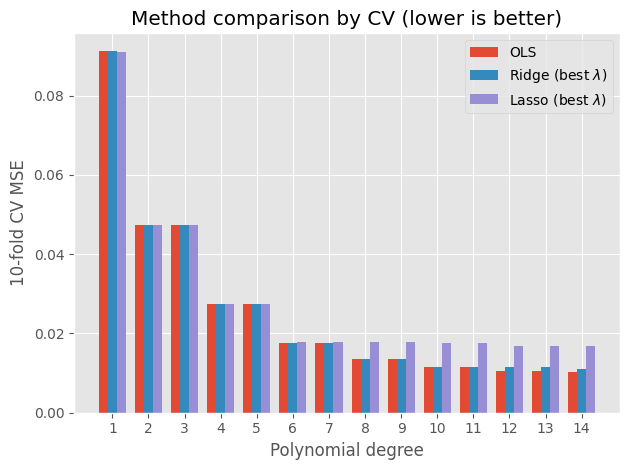

In [ ]:
idx = np.arange(len(summary_df))
width = 0.25 

plt.figure()
plt.bar(idx - width, summary_df["ols_cv_mse"], width=width, label='OLS')
plt.bar(idx,         summary_df["ridge_best_mse"], width=width, label=r'Ridge (best $\lambda$)')
plt.bar(idx + width, summary_df["lasso_best_mse"], width=width, label=r'Lasso (best $\lambda$)')
plt.xticks(idx, [str(d) for d in summary_df["degree"]])
plt.xlabel('Polynomial degree')
plt.ylabel(f'{K}-fold CV MSE')
plt.title('Method comparison by CV (lower is better)')
plt.legend()
plt.tight_layout()
plt.show()

# Tren beste modeller og rapporter hold-out Test-MSE

OLS   (deg=14)                     Test MSE: 0.010280
Ridge (deg=14, alpha=1.000e-04) Test MSE: 0.011016
Lasso (deg=14, alpha=1.000e-04) Test MSE: 0.016365


<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_61039/2983868521.py:43: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (d={best_deg_ridge}, $\lambda$={best_lambda_ridge:.2e})')
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_61039/2983868521.py:44: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (d={best_deg_lasso}, $\lambda$={best_lambda_lasso:.2e})')


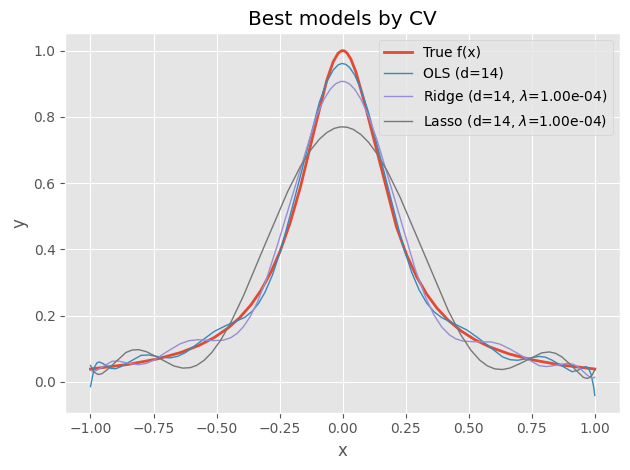

In [ ]:
best_deg_ols  = int(degrees[np.argmin(cv_mse_ols)])

# Finn globalt beste for Ridge/Lasso fra dine resultatsamlinger:
best_deg_ridge = int(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["degree"])
best_lambda_ridge = float(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["ridge_best_lambda"])
best_deg_lasso = int(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["degree"])
best_lambda_lasso = float(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["lasso_best_lambda"])

x_dense = np.linspace(-1, 1, 400)

ols_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_ols, include_bias=True),
    LinearRegression(fit_intercept=False)
)
ols_model.fit(x_train.reshape(-1,1), y_train)

ridge_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_ridge, include_bias=True),
    Ridge(alpha=best_lambda_ridge, fit_intercept=False, random_state=seed)
)
ridge_model.fit(x_train.reshape(-1,1), y_train)

lasso_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_lasso, include_bias=True),
    Lasso(alpha=best_lambda_lasso, fit_intercept=False,
          max_iter=300_000, tol=1e-3, selection="cyclic", random_state=seed)
)
lasso_model.fit(x_train.reshape(-1,1), y_train)

ols_test_mse   = mse(y_test,  ols_model.predict(x_test.reshape(-1,1)).ravel())
ridge_test_mse = mse(y_test, ridge_model.predict(x_test.reshape(-1,1)).ravel())
lasso_test_mse = mse(y_test, lasso_model.predict(x_test.reshape(-1,1)).ravel())

print(f"OLS   (deg={best_deg_ols})                     Test MSE: {ols_test_mse:.6f}")
print(f"Ridge (deg={best_deg_ridge}, alpha={best_lambda_ridge:.3e}) Test MSE: {ridge_test_mse:.6f}")
print(f"Lasso (deg={best_deg_lasso}, alpha={best_lambda_lasso:.3e}) Test MSE: {lasso_test_mse:.6f}")

plt.figure()
#plt.scatter(x_train, y_train, s=20, alpha=0.2, label='Train (noisy)')
#plt.scatter(x_test,  y_test,  s=20, alpha=0.2, label='Test (noisy)')
plt.plot(x_dense, f_true(x_dense), linewidth=2, label='True f(x)')
plt.plot(x_dense, ols_model.predict(x_dense.reshape(-1,1)).ravel(),   linewidth=1, label=f'OLS (d={best_deg_ols})')
plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (d={best_deg_ridge}, $\lambda$={best_lambda_ridge:.2e})')
plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (d={best_deg_lasso}, $\lambda$={best_lambda_lasso:.2e})')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Best models by CV')
plt.legend(); plt.tight_layout(); plt.show()


Tolkning:
OLS: treffer hovedformen ("en hump" rundt 0) uten å jage støy -> lav bias, moderat varians -> best generalisering her 

Ridge: lambda er ganske liten, så regulariseringen er nesten av. Med grad 12 blir kurven "bølgete", særlig mot kantene (|x| $\approx$ 1). Ser ut som høy varians/overfitting, derfor høyere test-MSE.

Lasso: med litt shrinkage, blir glattere/flatere enn OLS -> litt mer bias (undersmoothing) og mister toppens høyde -> også høyere test-mse.